In [1]:
import numpy as np
import scienceplots
from matplotlib import pyplot as plt
import matplotlib as mp
import pandas as pd
import os
import scipy as sp
import seaborn as sns
import json
import yaml
import functools
import itertools

In [2]:
resdir = "../c/results"
os.listdir(resdir)

['batch', 'multi-queue', 'base']

In [3]:
base_dir = f"{resdir}/base"
multi_dir = f"{resdir}/multi-queue"
batch_dir = f"{resdir}/batch"

In [4]:
dfs = {}

In [16]:
variant = "base"
dir = base_dir

summary_df = pd.read_csv(f"{dir}/{variant}_summary.csv")
summary_df = summary_df[summary_df.TotalConsumed == 10000]
summary_df['TotalSpinTime'] = summary_df['TotalSpinTime'] / 1e6
summary_df['TotalServiceTime'] = summary_df['TotalServiceTime'] / 1e6 
summary_df['TotalRunningTime'] = summary_df['TotalRunningTime'] / 1e6

summary_df['Throughput'] = summary_df.TotalConsumed * 1e-6 / summary_df.TotalRunningTime
# summary_df['SpinOverhead'] = summary_df.TotalSpinTime * 100 / summary_df.TotalRunningTime

minimal_duration = 10 * 10000 / 1e6
# Normalize TotalSpinTime, TotalServiceTime and TotalRunningTime to 10k consumed
summary_df['TotalSpinTime'] = summary_df['TotalSpinTime'] / minimal_duration
summary_df['TotalServiceTime'] = summary_df['TotalServiceTime'] / minimal_duration
summary_df['TotalRunningTime'] = summary_df['TotalRunningTime'] / minimal_duration

items = pd.read_csv(f"{dir}/{variant}_items.csv")
items = items[items.AccessTime != 0]
index = ['Variant', 'Consumers', 'ServiceTime']
df_latency = items.groupby(index).quantile(.99, numeric_only=True)['Latency']
df_waiters = items.groupby(index).quantile(.99, numeric_only=True)['Waiters']
df_access_time = items.groupby(index).quantile(.5, numeric_only=True)['AccessTime']

df_ = pd.concat([df_latency, df_waiters, df_access_time], axis=1)

df = summary_df.groupby(index).median(numeric_only=True)



In [19]:
df__ = pd.concat([df, df_], axis=1).reset_index()

df__['Throughput'] = df__['Throughput'] * df__['Consumers']

time_indices = ['TotalRunningTime', 'TotalSpinTime', 'TotalServiceTime']
for idx in time_indices:
    df__[idx] = df__[idx] * df__['Consumers']

In [22]:
df__ = df__[df__.Consumers <= 40]

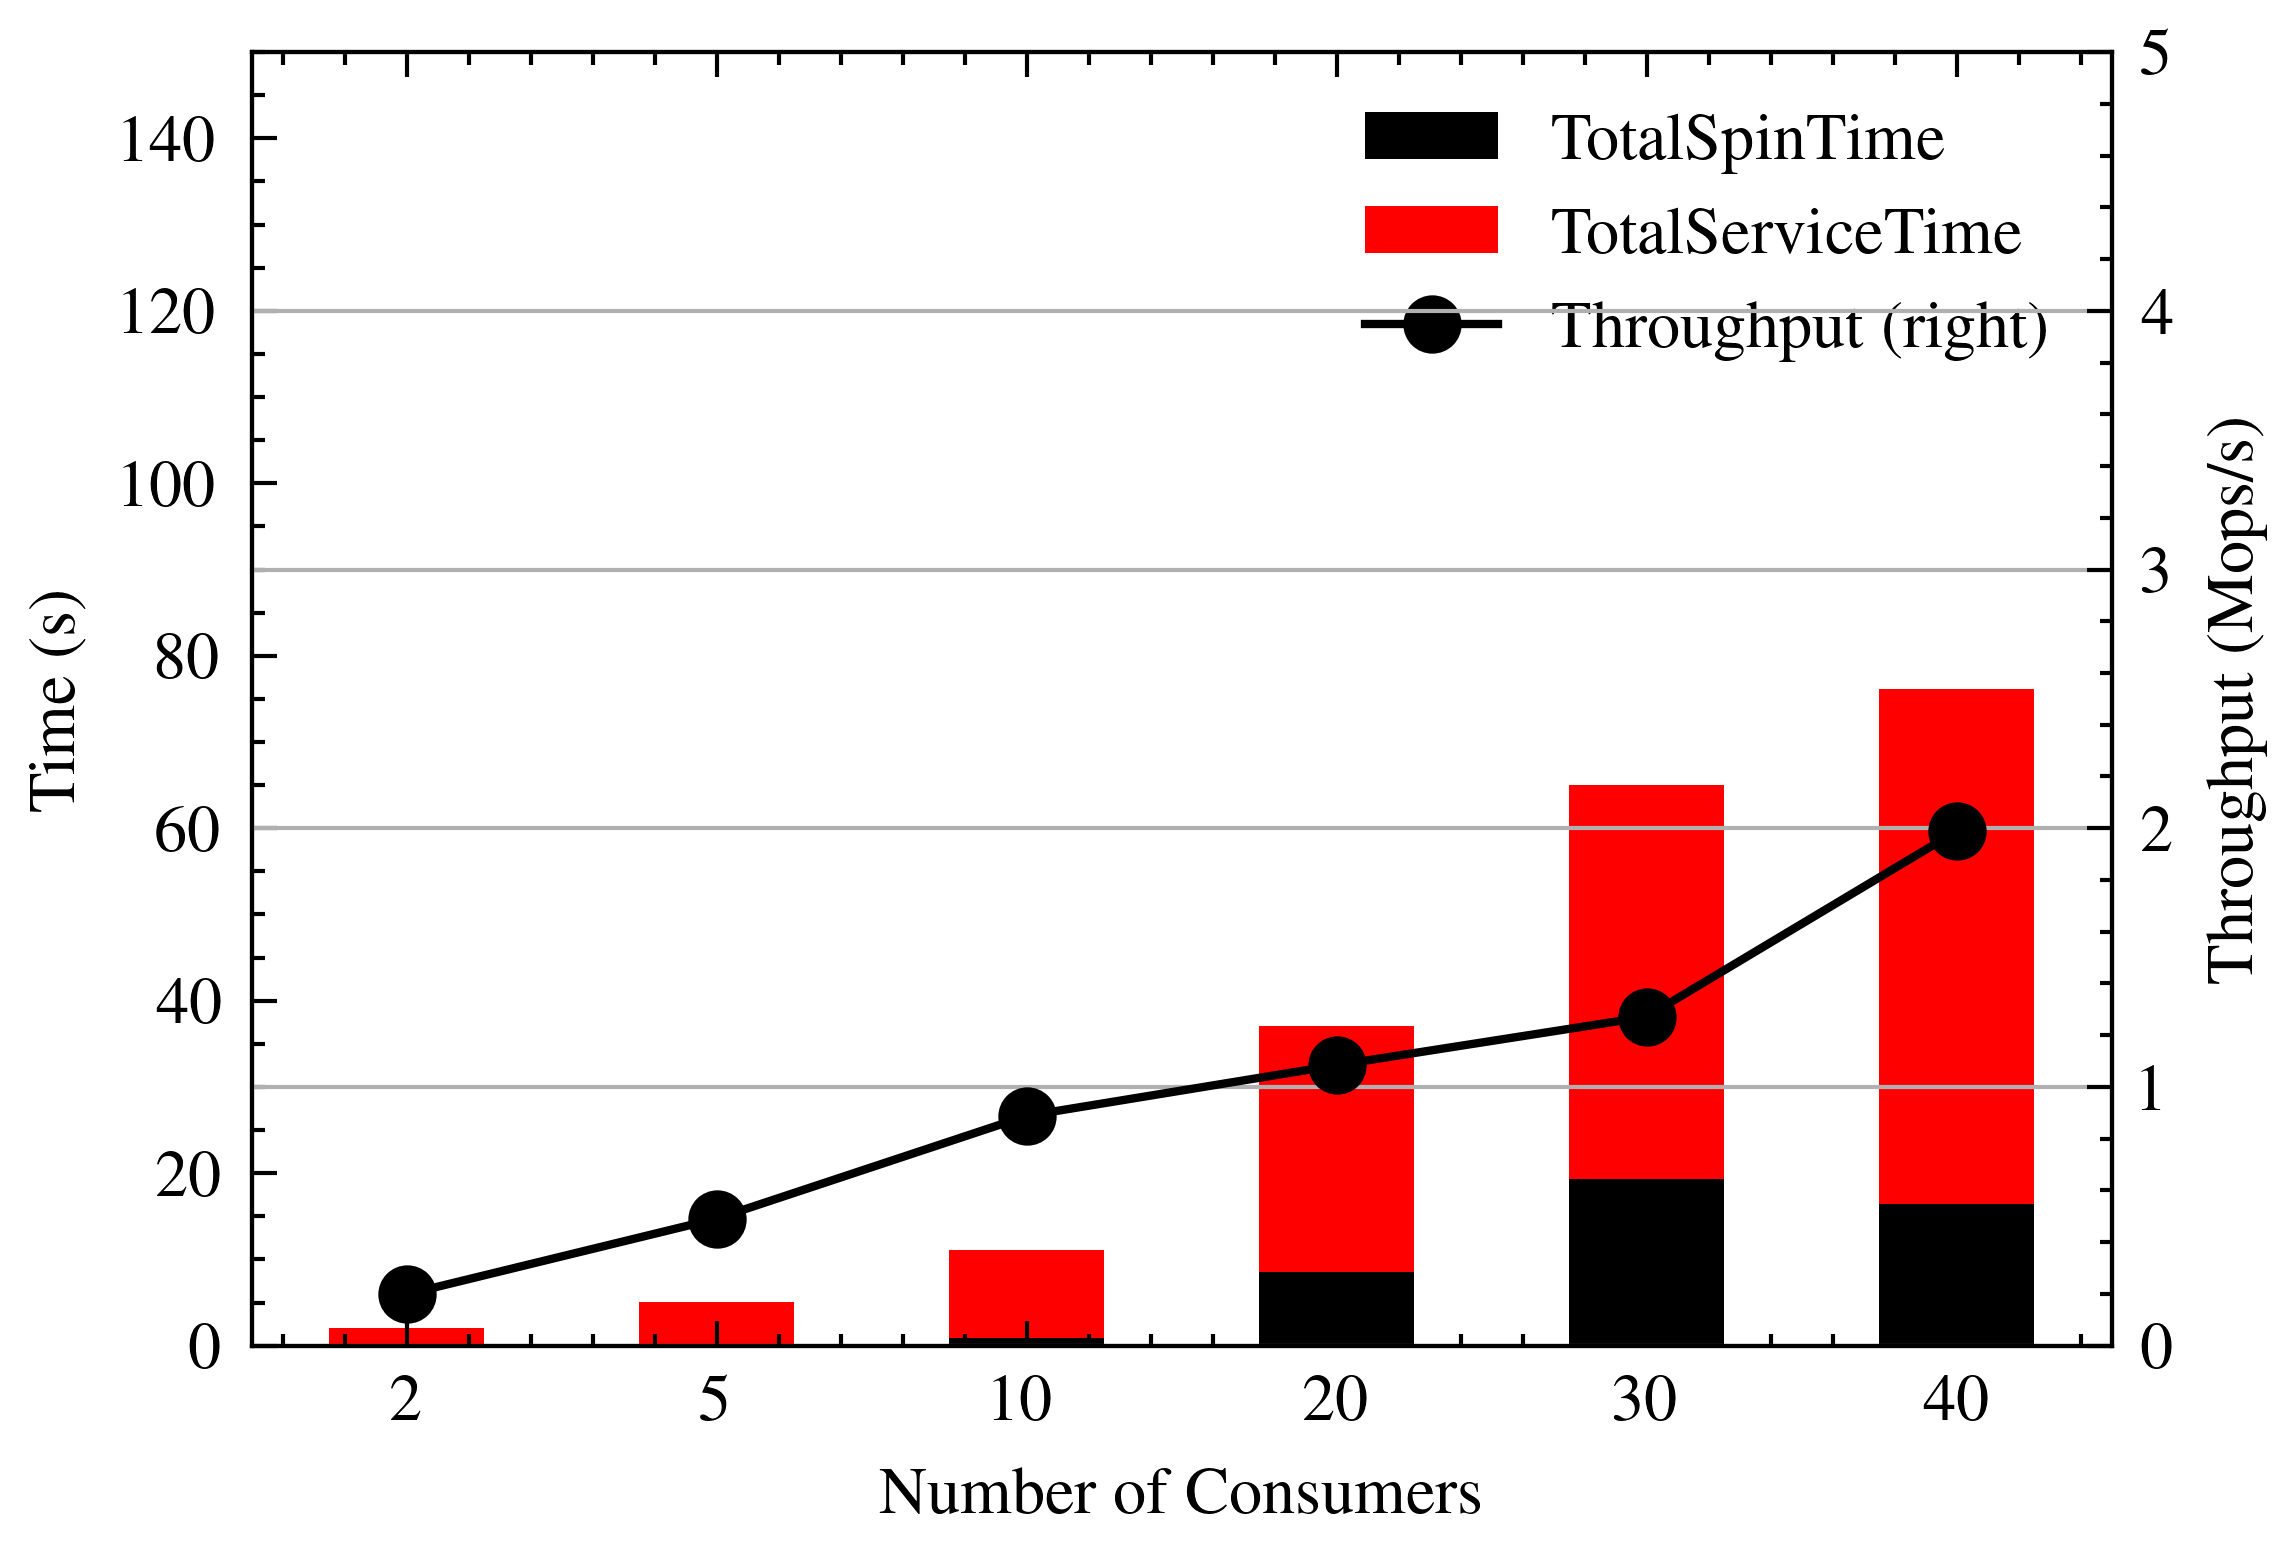

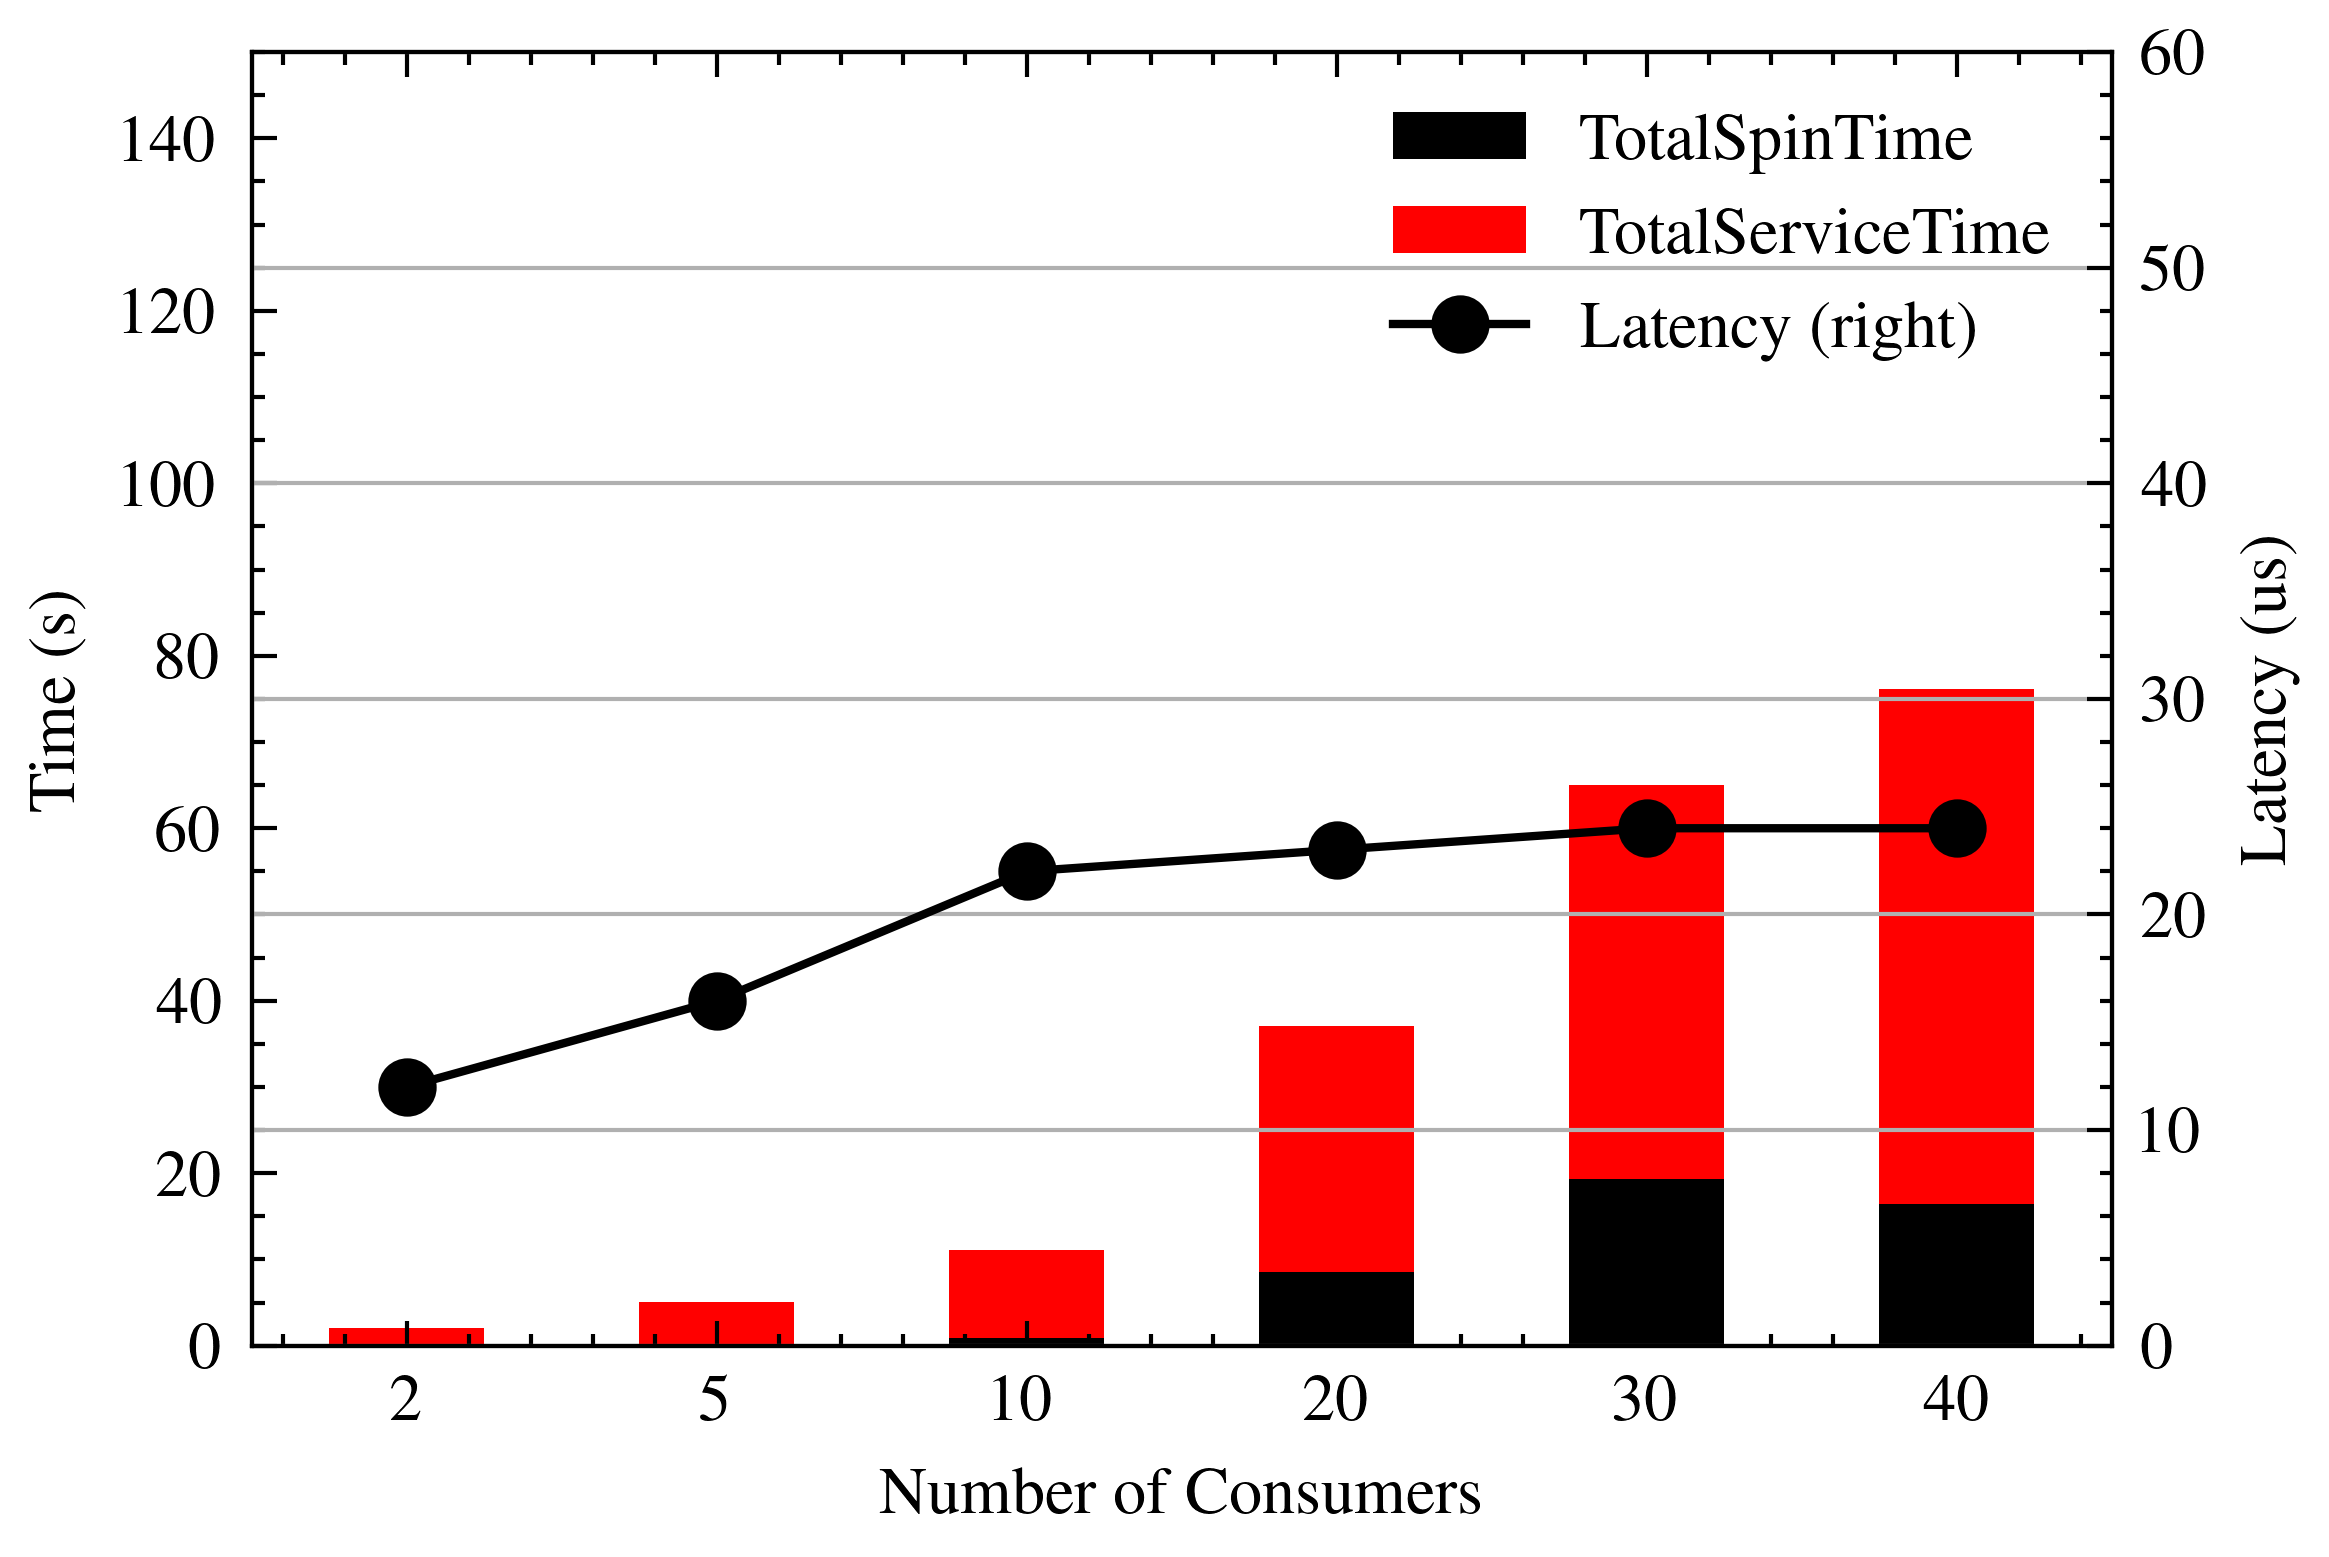

In [25]:
plt.rcParams.update({'font.size': 25})
figsize = (4,2.8)

with plt.style.context(['science', 'ieee']):
    # with plt.style.context(['science', 'ieee']):
    ax1 = df__.plot.bar(figsize=figsize, 
        xlabel='Number of Consumers',
        y=['TotalSpinTime', 'TotalServiceTime'], 
        stacked=True, capsize=5, rot=0,
        ylabel="Time (s)", ylim=(0, 150))
    ax2 = df__.plot.line(
        y='Throughput', ax=ax1, color='black', 
        marker='o', secondary_y=True, grid=True, 
        ylabel="Throughput (Mops/s)", ylim=[0, 5])
    
    ax1.set_xticklabels(df__.Consumers)
    ax2.set_xticklabels(df__.Consumers)
    # plt.legend(loc='upper right')
    plt.savefig("scq-throughpt.pdf")
    plt.show()
    
    # with plt.style.context(['science', 'ieee']):
    ax1 = df__.plot.bar(figsize=figsize, 
                        xlabel='Number of Consumers',
        y=['TotalSpinTime', 'TotalServiceTime'], 
        stacked=True, capsize=5, rot=0, 
        ylabel="Time (s)", ylim=(0, 150))
    ax2 = df__.plot.line(
        y='Latency', ax=ax1, color='black', 
        marker='o', secondary_y=True, grid=True, 
        ylabel="Latency (us)", ylim=[0, 60])
    
    ax1.set_xticklabels(df__.Consumers)
    ax2.set_xticklabels(df__.Consumers)
    # plt.legend(loc='upper right')
    plt.savefig("scq-latency.pdf")
    plt.show()
    dfs[variant] = df__

In [26]:
variant = "multi"
dir = multi_dir

summary_df = pd.read_csv(f"{dir}/{variant}_summary.csv")
summary_df = summary_df[summary_df.TotalConsumed == 10000]
summary_df['TotalSpinTime'] = summary_df['TotalSpinTime'] / 1e6
summary_df['TotalServiceTime'] = summary_df['TotalServiceTime'] / 1e6 
summary_df['TotalRunningTime'] = summary_df['TotalRunningTime'] / 1e6

summary_df['Throughput'] = summary_df.TotalConsumed * 1e-6 / summary_df.TotalRunningTime
# summary_df['SpinOverhead'] = summary_df.TotalSpinTime * 100 / summary_df.TotalRunningTime

minimal_duration = 10 * 10000 / 1e6
# Normalize TotalSpinTime, TotalServiceTime and TotalRunningTime to 10k consumed
summary_df['TotalSpinTime'] = summary_df['TotalSpinTime'] / minimal_duration
summary_df['TotalServiceTime'] = summary_df['TotalServiceTime'] / minimal_duration
summary_df['TotalRunningTime'] = summary_df['TotalRunningTime'] / minimal_duration

items = pd.read_csv(f"{dir}/{variant}_items.csv")
items = items[items.AccessTime != 0]
index = ['Variant', 'Consumers', 'ServiceTime']
df_latency = items.groupby(index).quantile(.99, numeric_only=True)['Latency']
df_waiters = items.groupby(index).quantile(.99, numeric_only=True)['Waiters']
df_access_time = items.groupby(index).quantile(.5, numeric_only=True)['AccessTime']

df_ = pd.concat([df_latency, df_waiters, df_access_time], axis=1)

df = summary_df.groupby(index).median(numeric_only=True)

df__ = pd.concat([df, df_], axis=1).reset_index().dropna()

df__['Throughput'] = df__['Throughput'] * df__['Consumers']

In [27]:
df__ = df__[df__.Consumers <= 40]

In [28]:
time_indices = ['TotalRunningTime', 'TotalSpinTime', 'TotalServiceTime']
for idx in time_indices:
    df__[idx] = df__[idx] * df__['Consumers']
dfs[variant] = df__

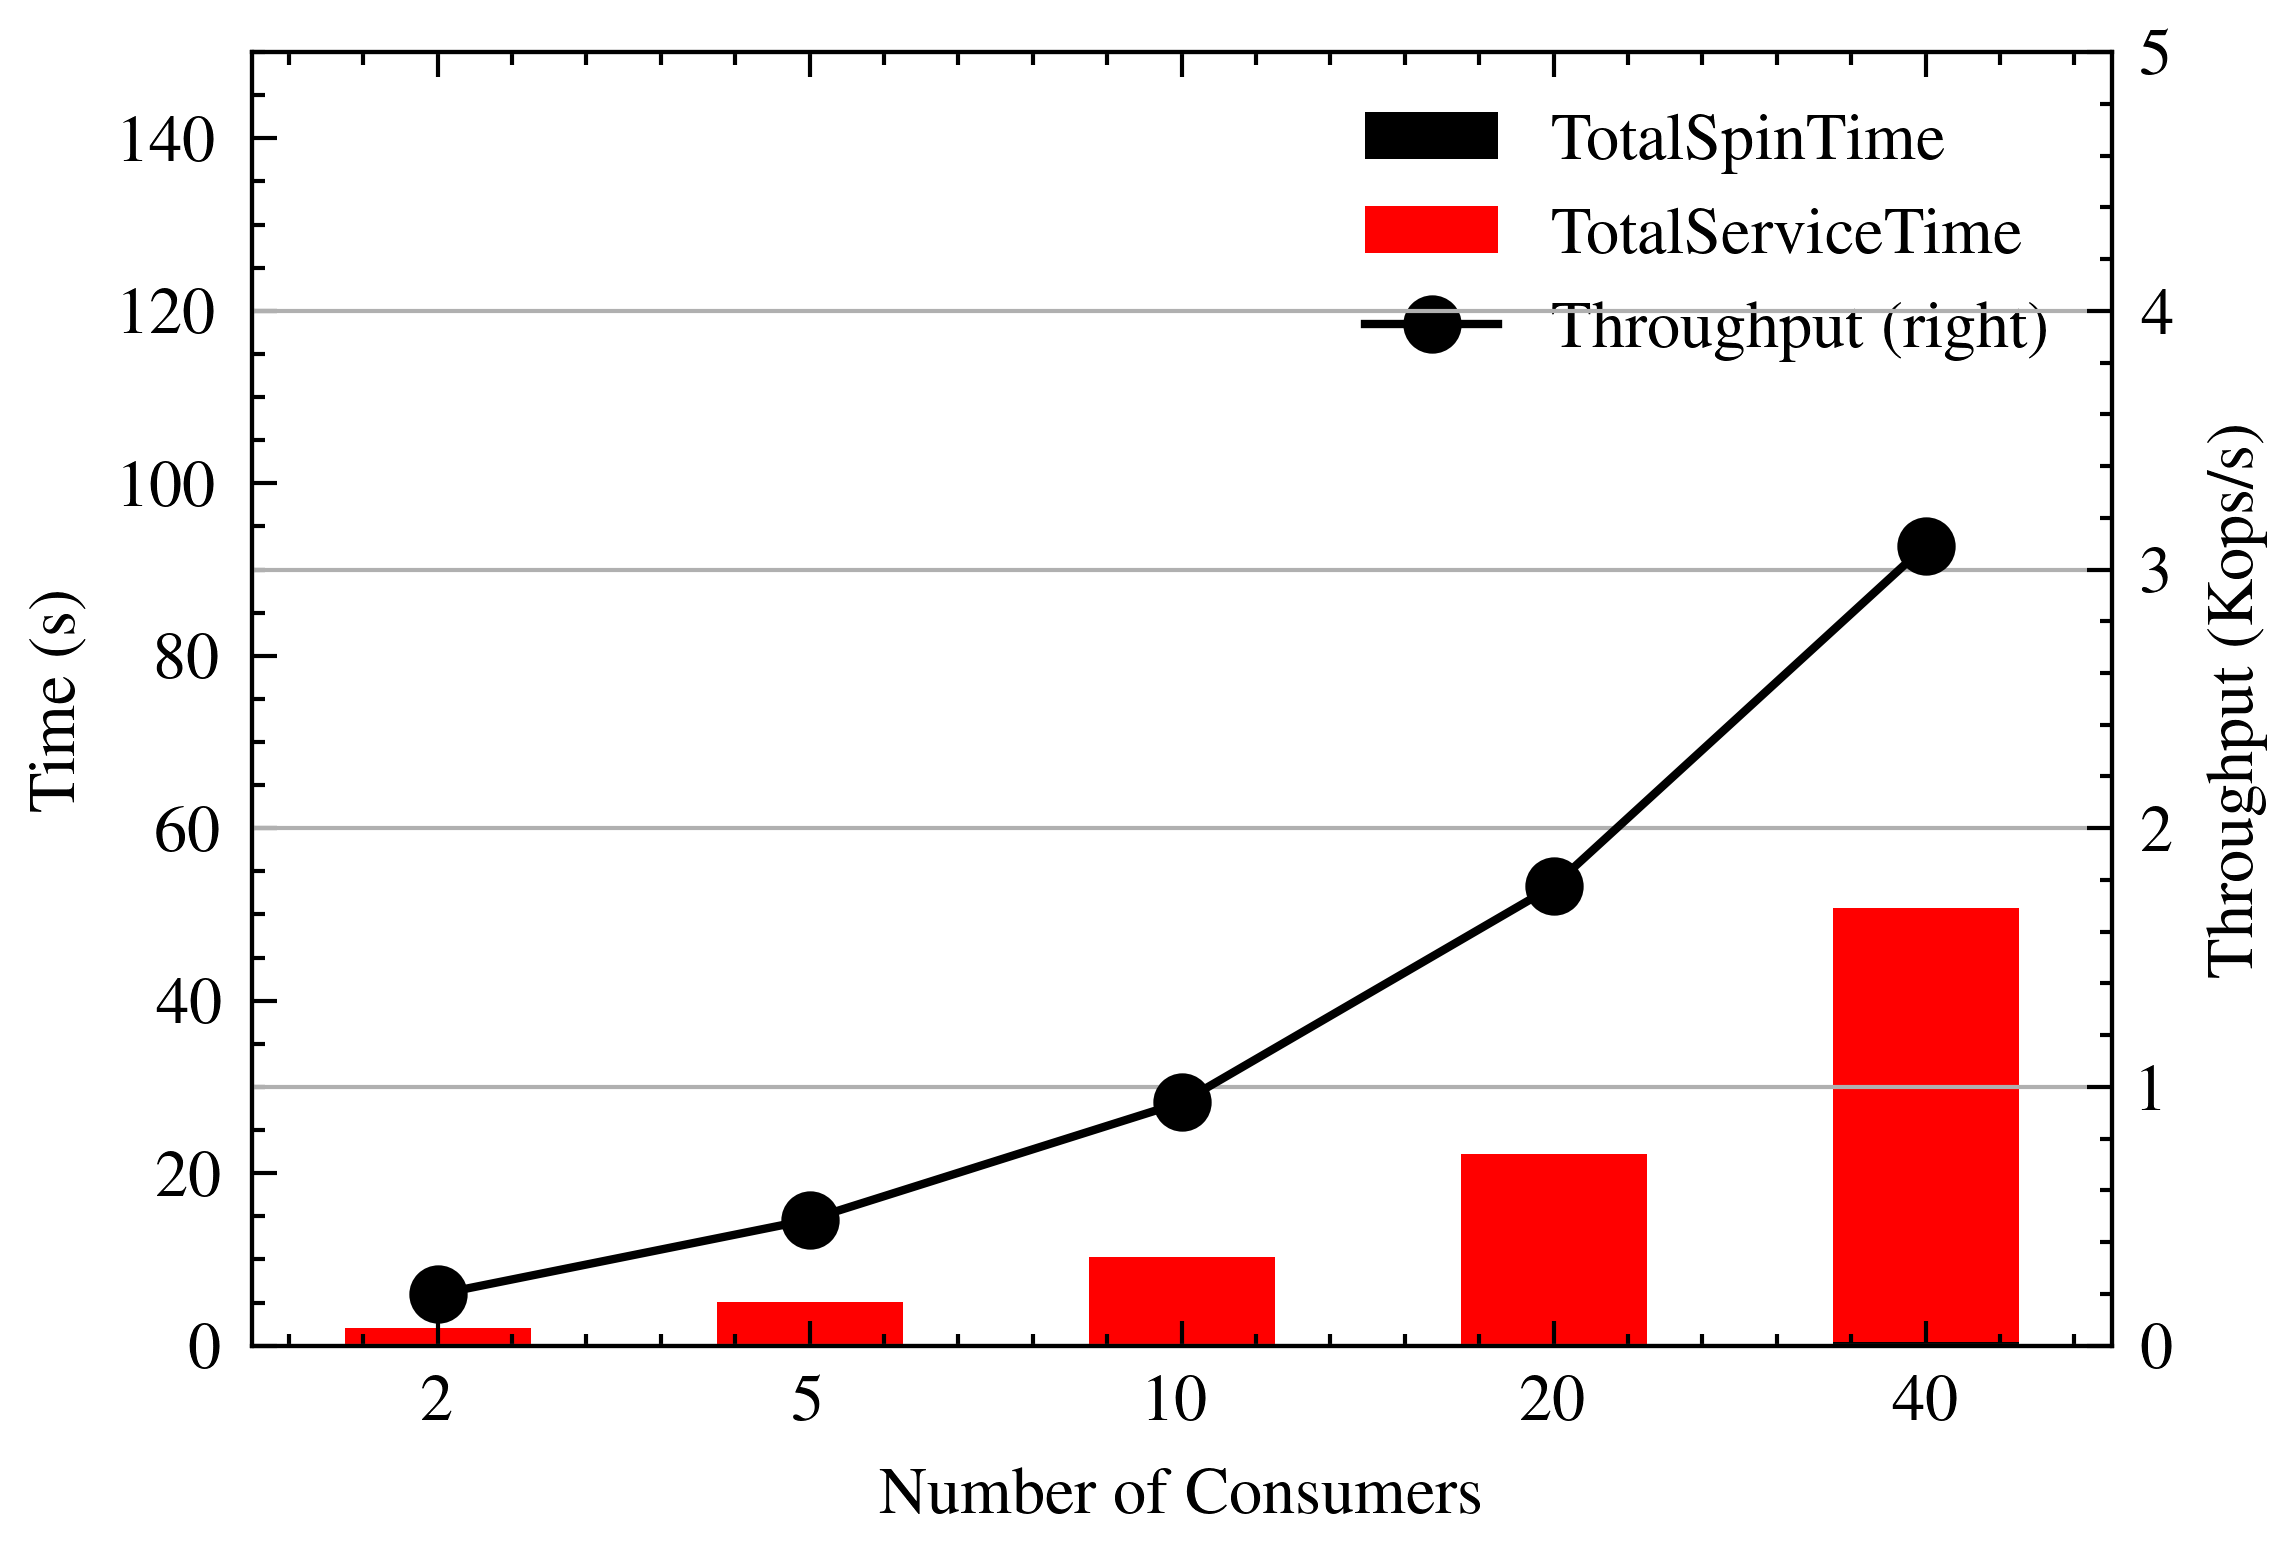

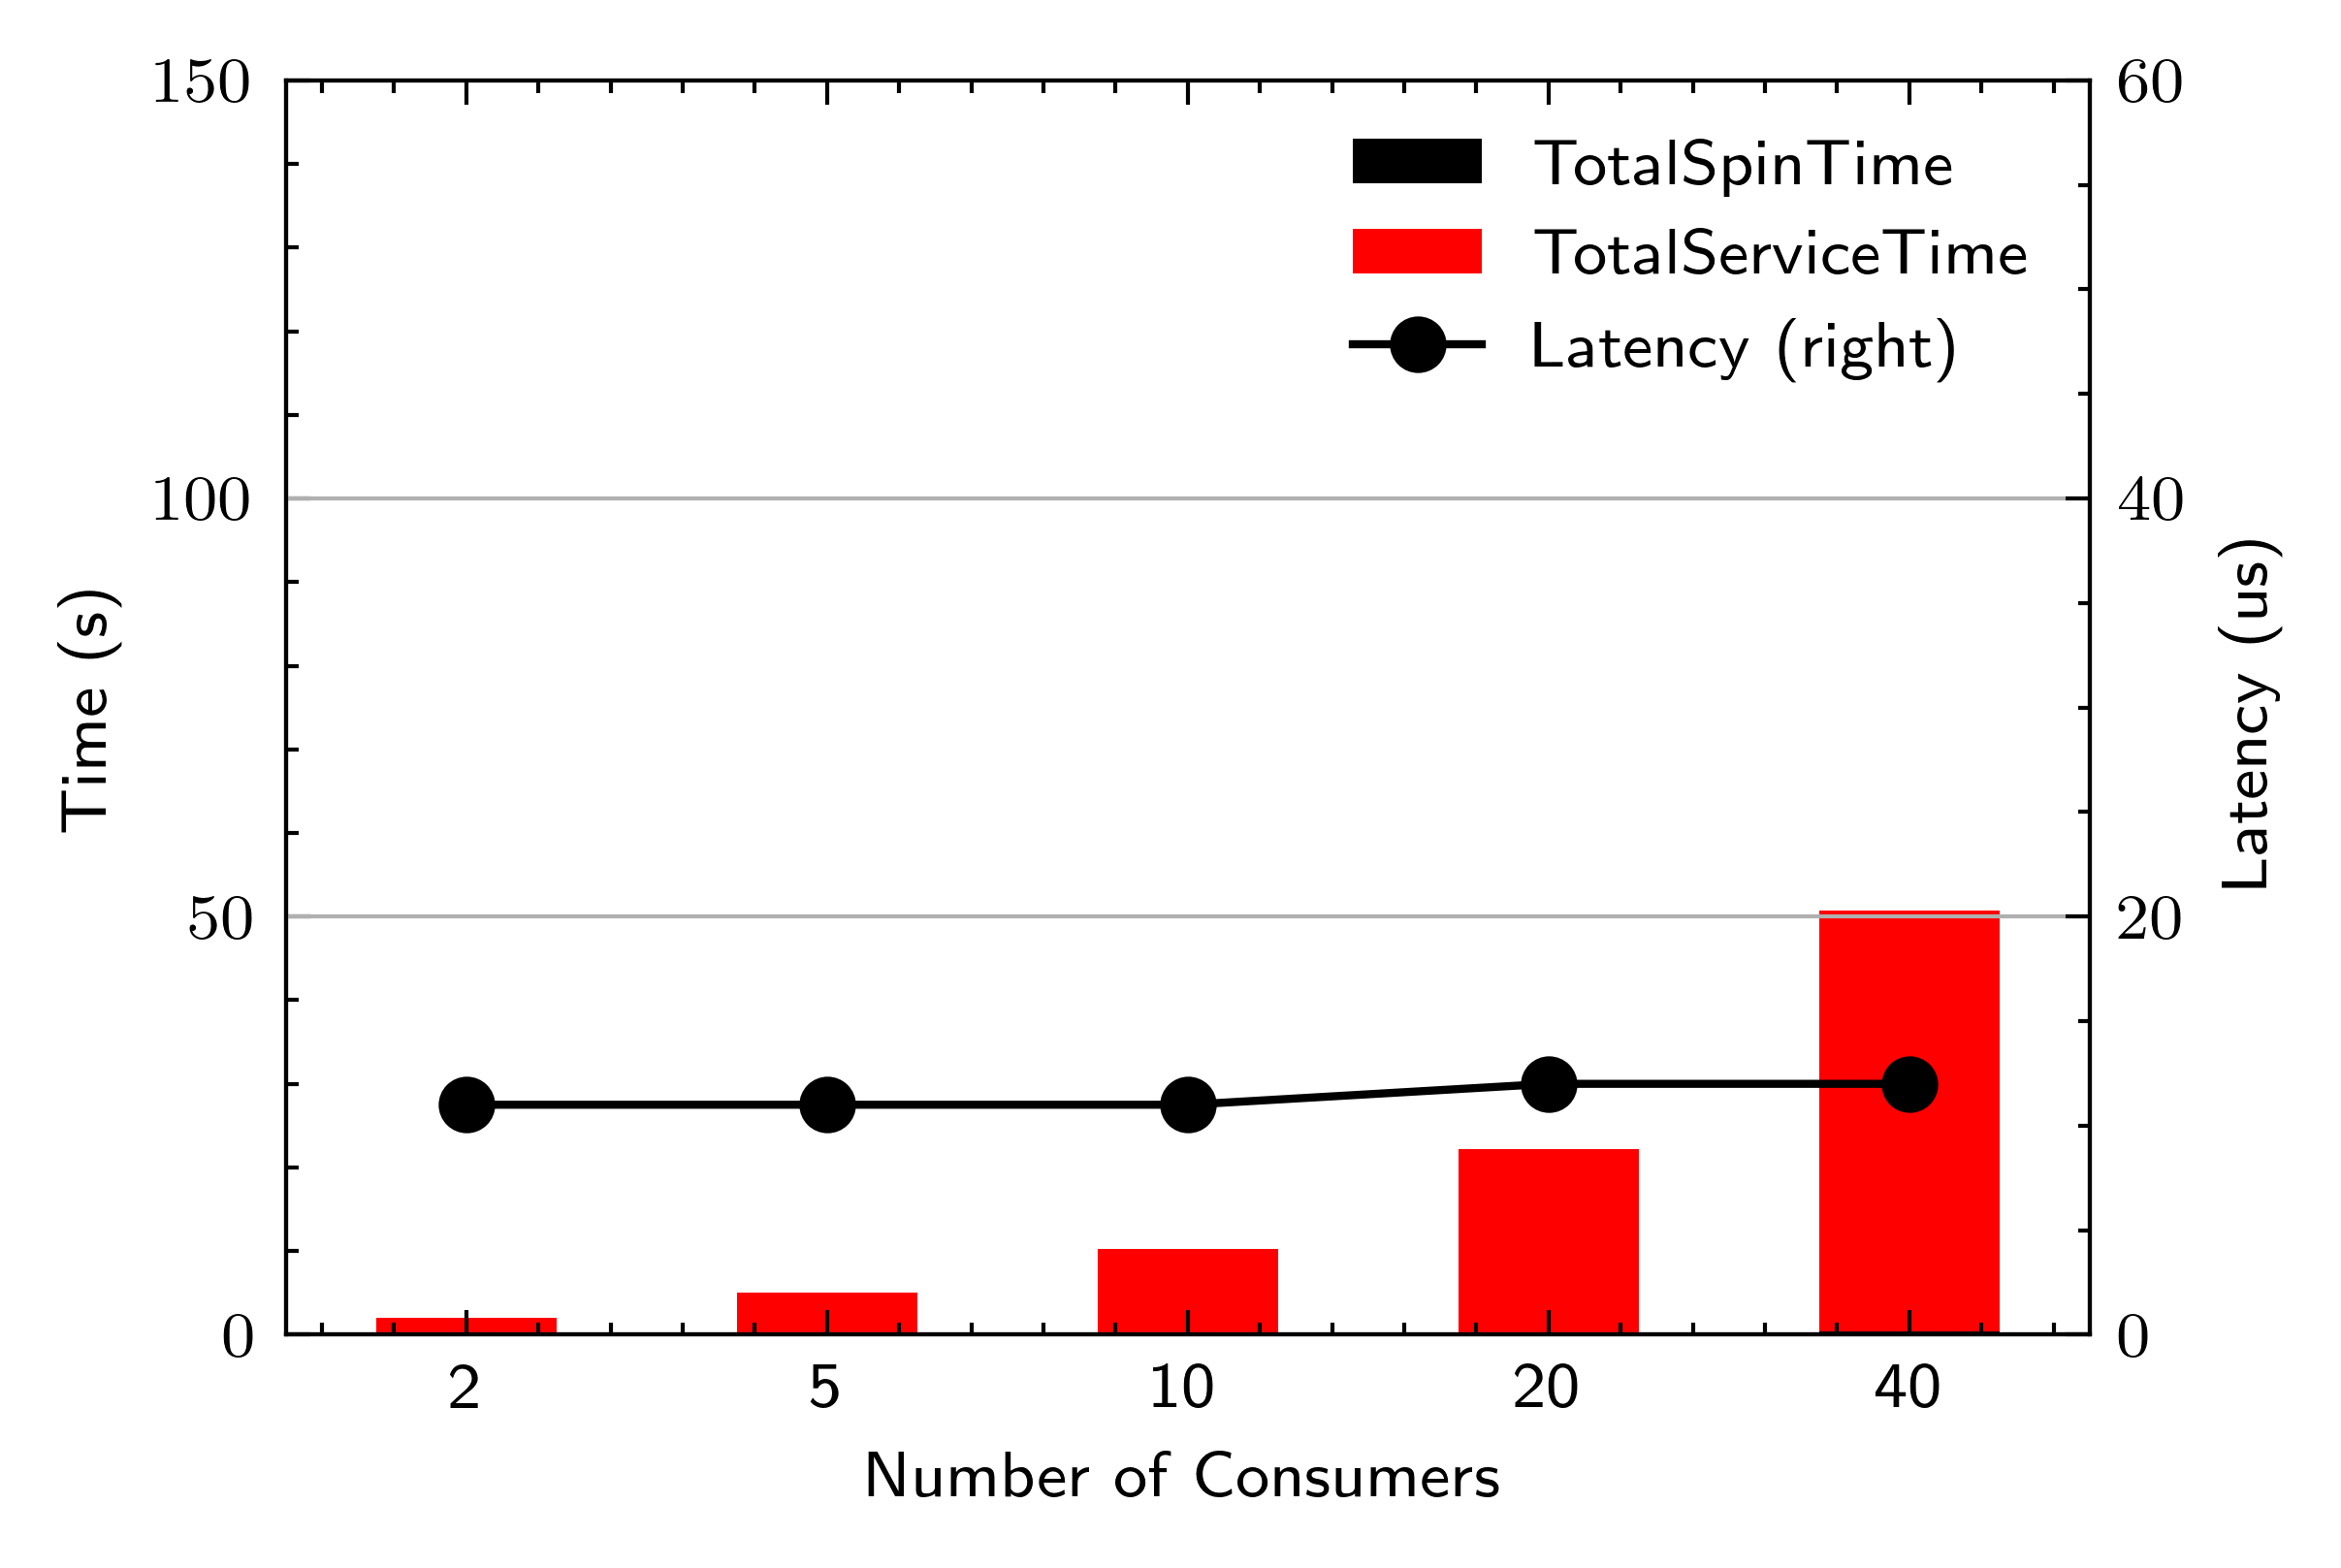

In [33]:
with plt.style.context(['science', 'ieee']):
    # with plt.style.context(['science', 'ieee']):
    ax1 = df__.plot.bar(figsize=figsize, xlabel="Number of Consumers",
        y=['TotalSpinTime', 'TotalServiceTime'], 
        stacked=True, capsize=5, rot=0,
        ylabel="Time (s)", ylim=(0, 150))
    ax2 = df__.plot.line(
        y='Throughput', ax=ax1, color='black', 
        marker='o', secondary_y=True, grid=True,
        ylabel="Throughput (Kops/s)", ylim=[0, 5])
    
    ax1.set_xticklabels(df__.Consumers)
    ax2.set_xticklabels(df__.Consumers)
    plt.savefig('mq-throughput.pdf')
    # plt.legend(loc='upper right')
    plt.show()
    
    # with plt.style.context(['science', 'ieee']):
    ax1 = df__.plot.bar(figsize=figsize, xlabel="Number of Consumers",
        y=['TotalSpinTime', 'TotalServiceTime'], 
        stacked=True, capsize=5, rot=0,
        ylabel="Time (s)", ylim=(0, 150))
    ax2 = df__.plot.line(
        y='Latency', ax=ax1, color='black', 
        marker='o', secondary_y=True, grid=True,
        ylabel="Latency (us)", ylim=[0, 60])

ax1.set_xticklabels(df__.Consumers)
ax2.set_xticklabels(df__.Consumers)
plt.savefig('mq-latency.pdf')
# plt.legend(loc='upper left')
plt.show()


In [34]:
variant = "batch"
dir = batch_dir

summary_df = pd.read_csv(f"{dir}/{variant}_summary.csv")
summary_df = summary_df[summary_df.TotalConsumed == 10000]
summary_df['TotalSpinTime'] = summary_df['TotalSpinTime'] / 1e6
summary_df['TotalServiceTime'] = summary_df['TotalServiceTime'] / 1e6 
summary_df['TotalRunningTime'] = summary_df['TotalRunningTime'] / 1e6


summary_df['Throughput'] = summary_df.TotalConsumed * 1e-6 / summary_df.TotalRunningTime
# summary_df['SpinOverhead'] = summary_df.TotalSpinTime * 100 / summary_df.TotalRunningTime

minimal_duration = 10 * 10000 / 1e6
# Normalize TotalSpinTime, TotalServiceTime and TotalRunningTime to 10k consumed
summary_df['TotalSpinTime'] = summary_df['TotalSpinTime'] / minimal_duration
summary_df['TotalServiceTime'] = summary_df['TotalServiceTime'] / minimal_duration
summary_df['TotalRunningTime'] = summary_df['TotalRunningTime'] / minimal_duration


In [35]:
filepath = f"{dir}/{variant}_items.csv"
items = pd.read_csv(
    filepath,
    chunksize=1000000,
    low_memory=True
)

In [36]:
index = ['Variant', 'Consumers', 'ServiceTime', 'BatchSize']

In [37]:
final = []
total_size = 0
for chunk in items:
    total_size += 1
    item = chunk[chunk.AccessTime != 0]
    numeric = pd.to_numeric(item.Latency, errors='coerce')
    item = item.copy()
    item['Latency'] = numeric
    item = item[~numeric.isna()]
    
    q99 = item.groupby(index).quantile(.99, numeric_only=True)
    q50 = item.groupby(index).quantile(.50, numeric_only=True)
    
    df_latency = q99['Latency']
    df_waiters = q99['Waiters']
    df_access_time = q50['AccessTime']
    
    final.append(pd.concat([df_latency, df_waiters, df_access_time], axis=1).reset_index())

In [38]:
total_group = total_size
total_size = total_size * 1000000
weight = 1000000 / total_size

In [39]:
grouped = pd.concat(final, axis=0).groupby(index)
idx = ['Latency', 'Waiters']
df_ = grouped.quantile(.99)[idx]
df_['AccessTime'] = grouped.quantile(.50)['AccessTime']
df = summary_df.groupby(index).median(numeric_only=True)
df__ = pd.concat([df, df_], axis=1).reset_index().dropna()

In [40]:
df__['Throughput'] = df__['Throughput'] * df__['Consumers']

time_indices = ['TotalRunningTime', 'TotalSpinTime', 'TotalServiceTime']
for idx in time_indices:
    df__[idx] = df__[idx] * df__['Consumers']

In [41]:
print(df__.Consumers.unique())
print(df__.BatchSize.unique())

[ 2  5 10 20 30 40 50 60]
[ 1  2  4  8 16 32]


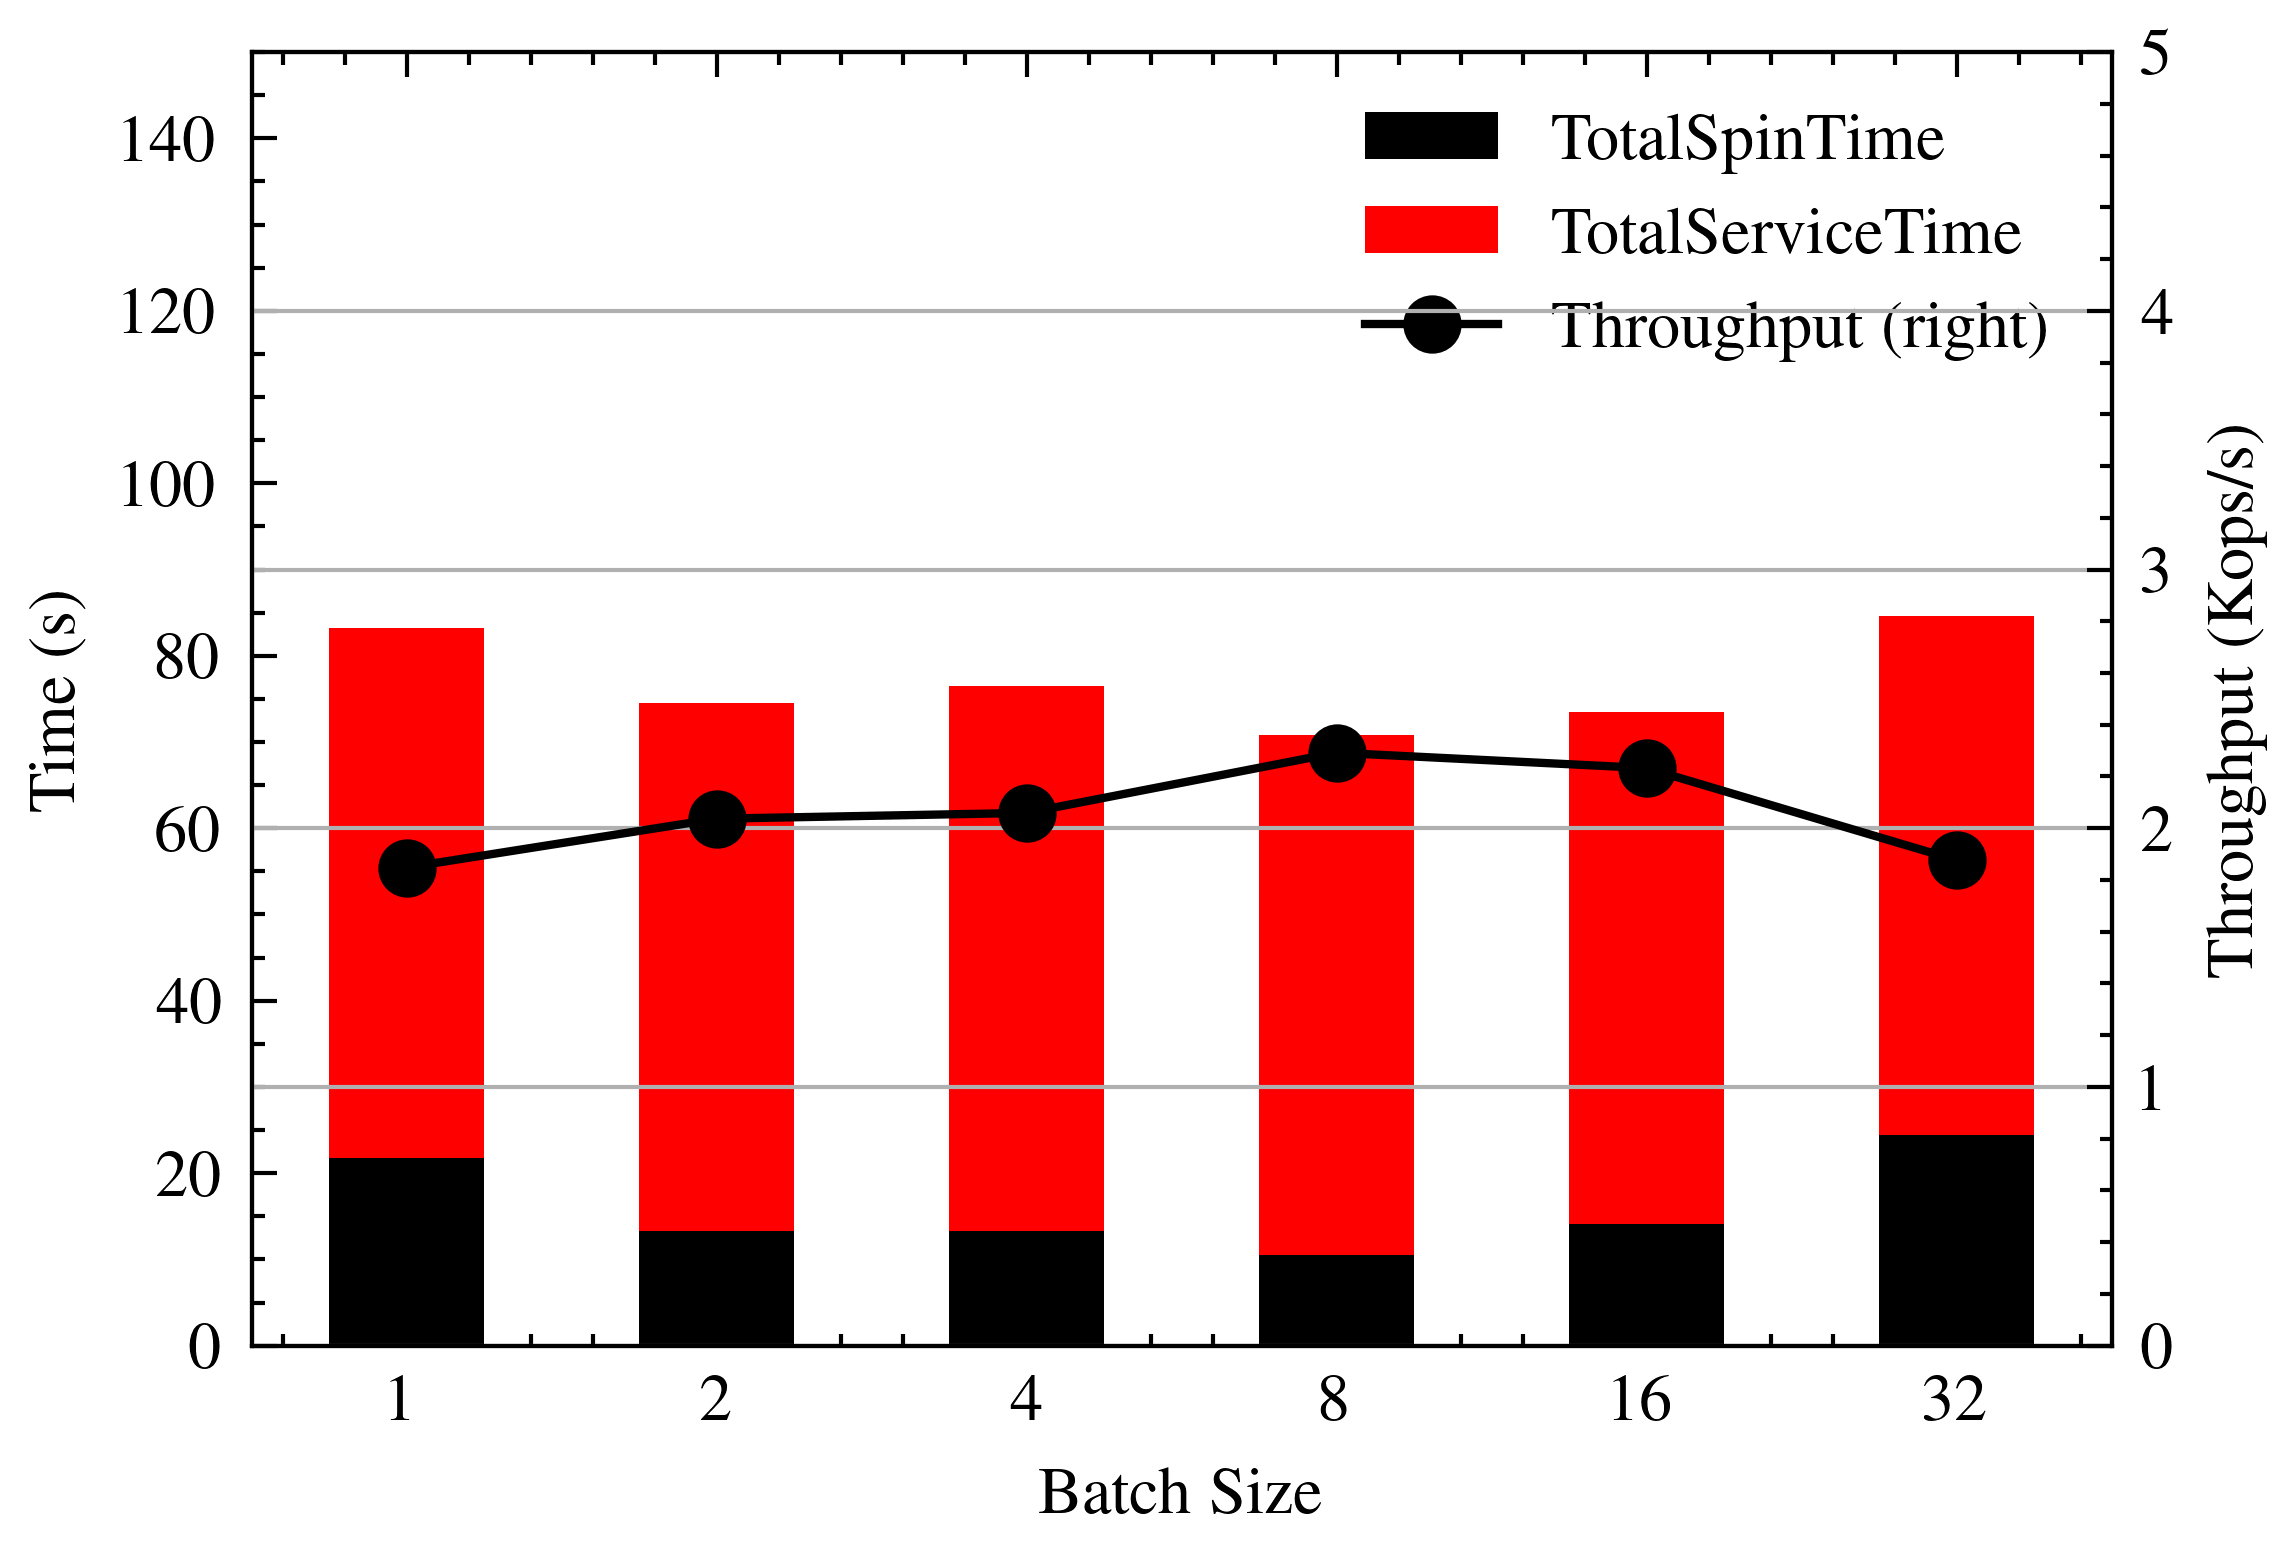

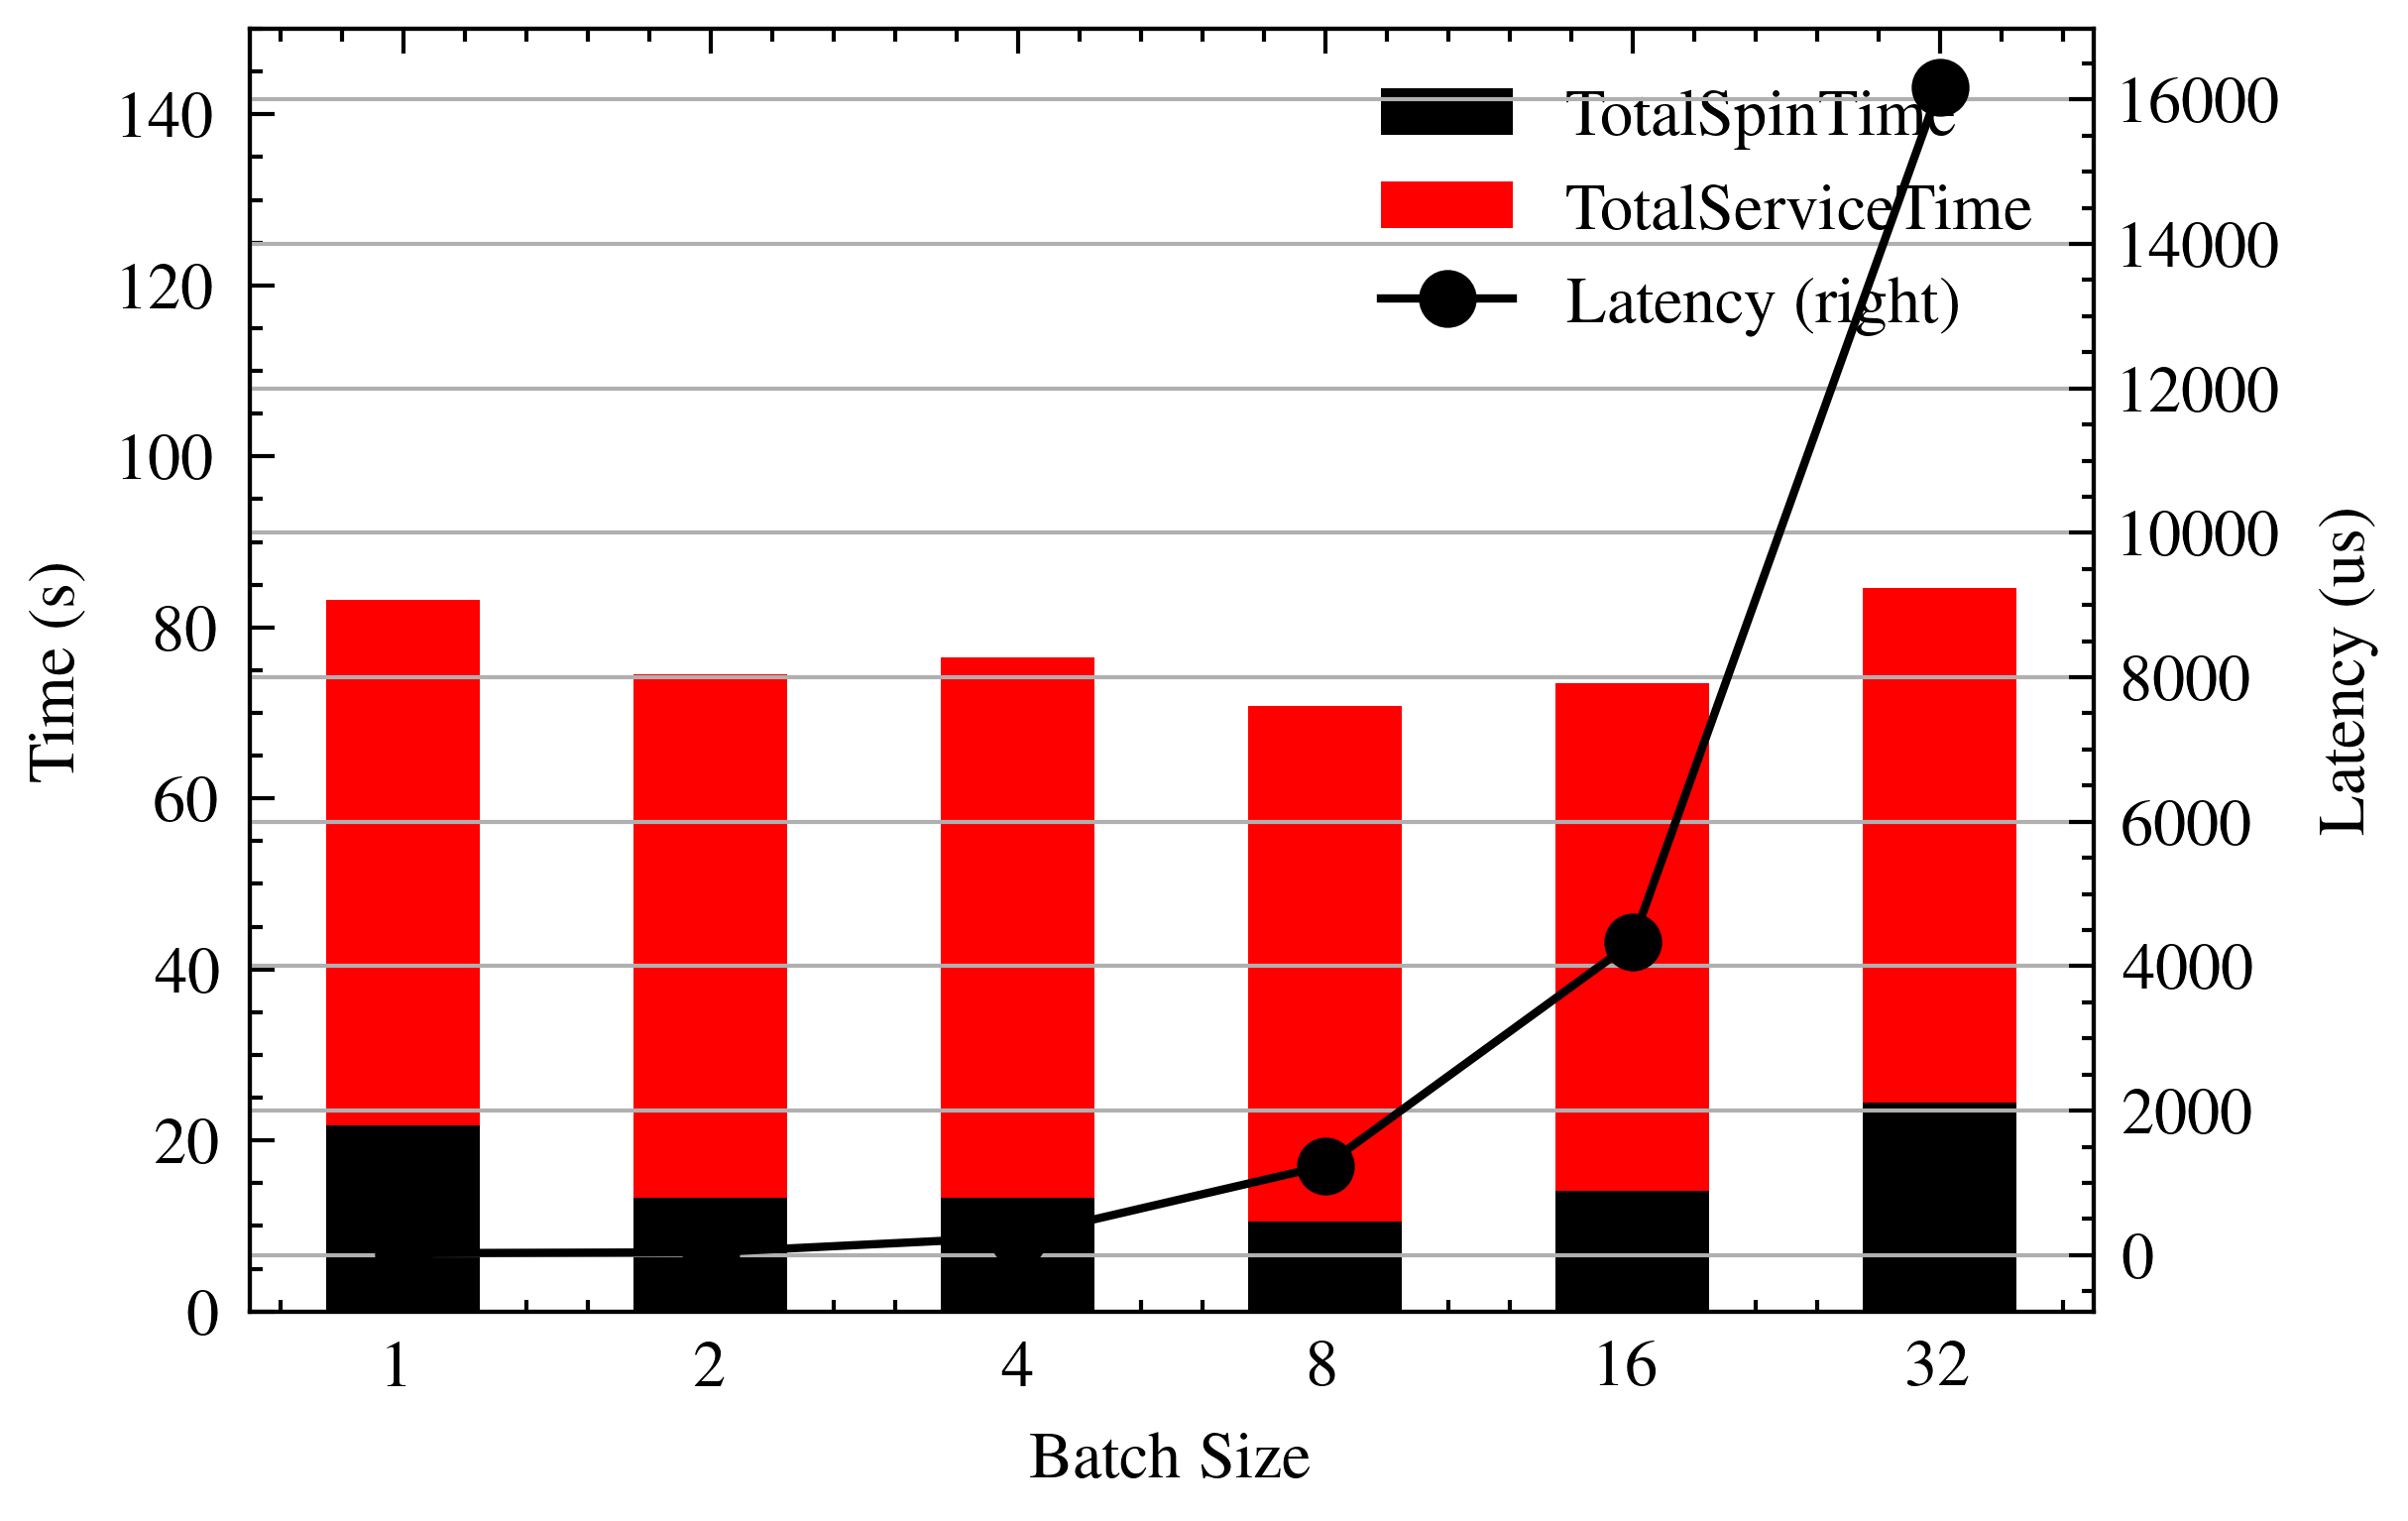

In [46]:
consumers = 40
df = df__[df__.Consumers == consumers].reset_index(drop=True)

with plt.style.context(['science', 'ieee']):
    # with plt.style.context(['science', 'ieee']):
    ax1 = df.plot.bar(figsize=figsize, xlabel='Batch Size',
        y=['TotalSpinTime', 'TotalServiceTime'], 
        stacked=True, capsize=5, rot=0, 
        ylabel="Time (s)", ylim=(0, 150))
    ax2 = df.plot.line(
        y='Throughput', ax=ax1, color='black', 
        marker='o', secondary_y=True, grid=True, 
        ylabel="Throughput (Kops/s)", ylim=[0, 5])
    
    ax1.set_xticklabels(df.BatchSize)
    ax2.set_xticklabels(df.BatchSize)
    # plt.legend(loc='upper right')
    plt.savefig("batch-throughput.pdf")
    plt.show()
    
    df = df__[df__.Consumers == consumers].reset_index(drop=True)
    
    # with plt.style.context(['science', 'ieee']):
    ax1 = df.plot.bar(figsize=figsize, xlabel='Batch Size',
        y=['TotalSpinTime', 'TotalServiceTime'], 
        stacked=True, capsize=5, rot=0, 
        ylabel="Time (s)", ylim=(0, 150))
    ax2 = df.plot.line(
        y='Latency', ax=ax1, color='black', 
        marker='o', secondary_y=True, grid=True,
        ylabel="Latency (us)")

    ax1.set_xticklabels(df.BatchSize)
    ax2.set_xticklabels(df.BatchSize)
    plt.savefig("batch-latency.pdf")
    # plt.legend(loc='upper right')
    plt.show()

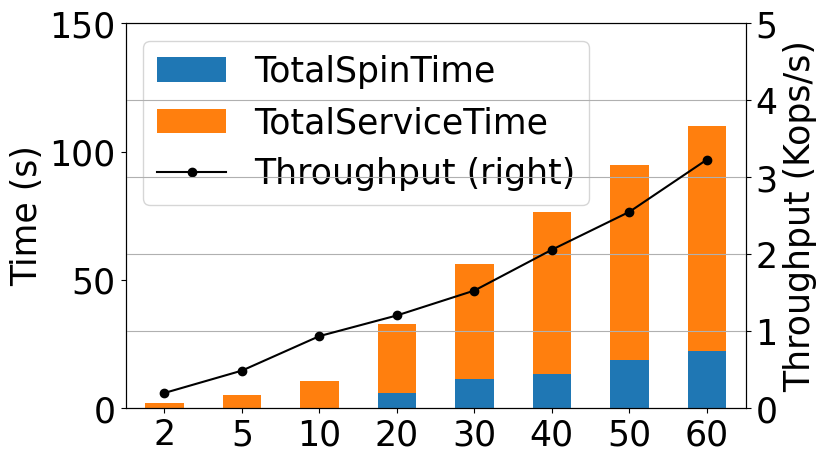

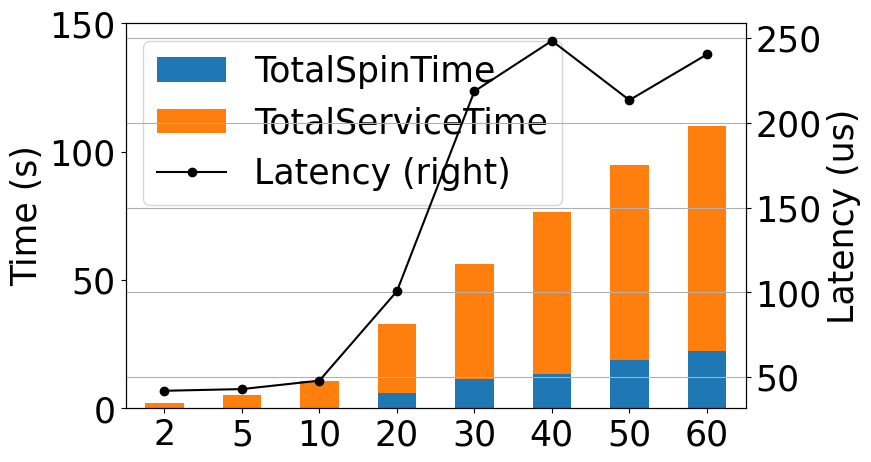

In [47]:
batchSize = 4
df = df__[df__.BatchSize == batchSize].reset_index(drop=True)

# with plt.style.context(['science', 'ieee']):
ax1 = df.plot.bar(figsize=(8, 5), 
    y=['TotalSpinTime', 'TotalServiceTime'], 
    stacked=True, capsize=5, rot=0, 
    ylabel="Time (s)", ylim=(0, 150))
ax2 = df.plot.line(
    y='Throughput', ax=ax1, color='black', 
    marker='o', secondary_y=True, grid=True, 
    ylabel="Throughput (Kops/s)", ylim=[0, 5])

ax1.set_xticklabels(df.Consumers)
ax2.set_xticklabels(df.Consumers)
# plt.legend(loc='upper right')
plt.show()

# with plt.style.context(['science', 'ieee']):
ax1 = df.plot.bar(figsize=(8, 5), 
    y=['TotalSpinTime', 'TotalServiceTime'], 
    stacked=True, capsize=5, rot=0, 
    ylabel="Time (s)", ylim=(0, 150))
ax2 = df.plot.line(
    y='Latency', ax=ax1, color='black', 
    marker='o', secondary_y=True, grid=True, 
    ylabel="Latency (us)")

ax1.set_xticklabels(df.Consumers)
ax2.set_xticklabels(df.Consumers)
# plt.legend(loc='upper right')
plt.show()

In [48]:
dfs['batch'] = df

In [49]:
df_final = dfs.values()
df_final = pd.concat(df_final, axis=0)

In [50]:
throughput = df_final.pivot(index='Consumers', columns='Variant', values='Throughput').dropna()
throughput = throughput.reset_index()
throughput['baseline'] = throughput['Consumers'] * 0.1

In [51]:
latency = df_final.pivot(index='Consumers', columns='Variant', values='Latency').dropna()
latency = latency.reset_index()
latency['baseline'] = 10

In [52]:
cpu_time = df_final.pivot(index='Consumers', columns='Variant', values='TotalRunningTime').dropna()
cpu_time = cpu_time.reset_index()
cpu_time['baseline'] = cpu_time['Consumers'] * 0.1

In [53]:
variants = ['base', 'batch', 'multi']

In [54]:
throughput

Variant,Consumers,base,batch,multi,baseline
0,2,0.198599,0.198697,0.198109,0.2
1,5,0.491082,0.489088,0.487028,0.5
2,10,0.888210,0.937226,0.940324,1.0
3,20,1.084198,1.205654,1.776752,2.0
4,40,1.988556,2.059344,3.092266,4.0


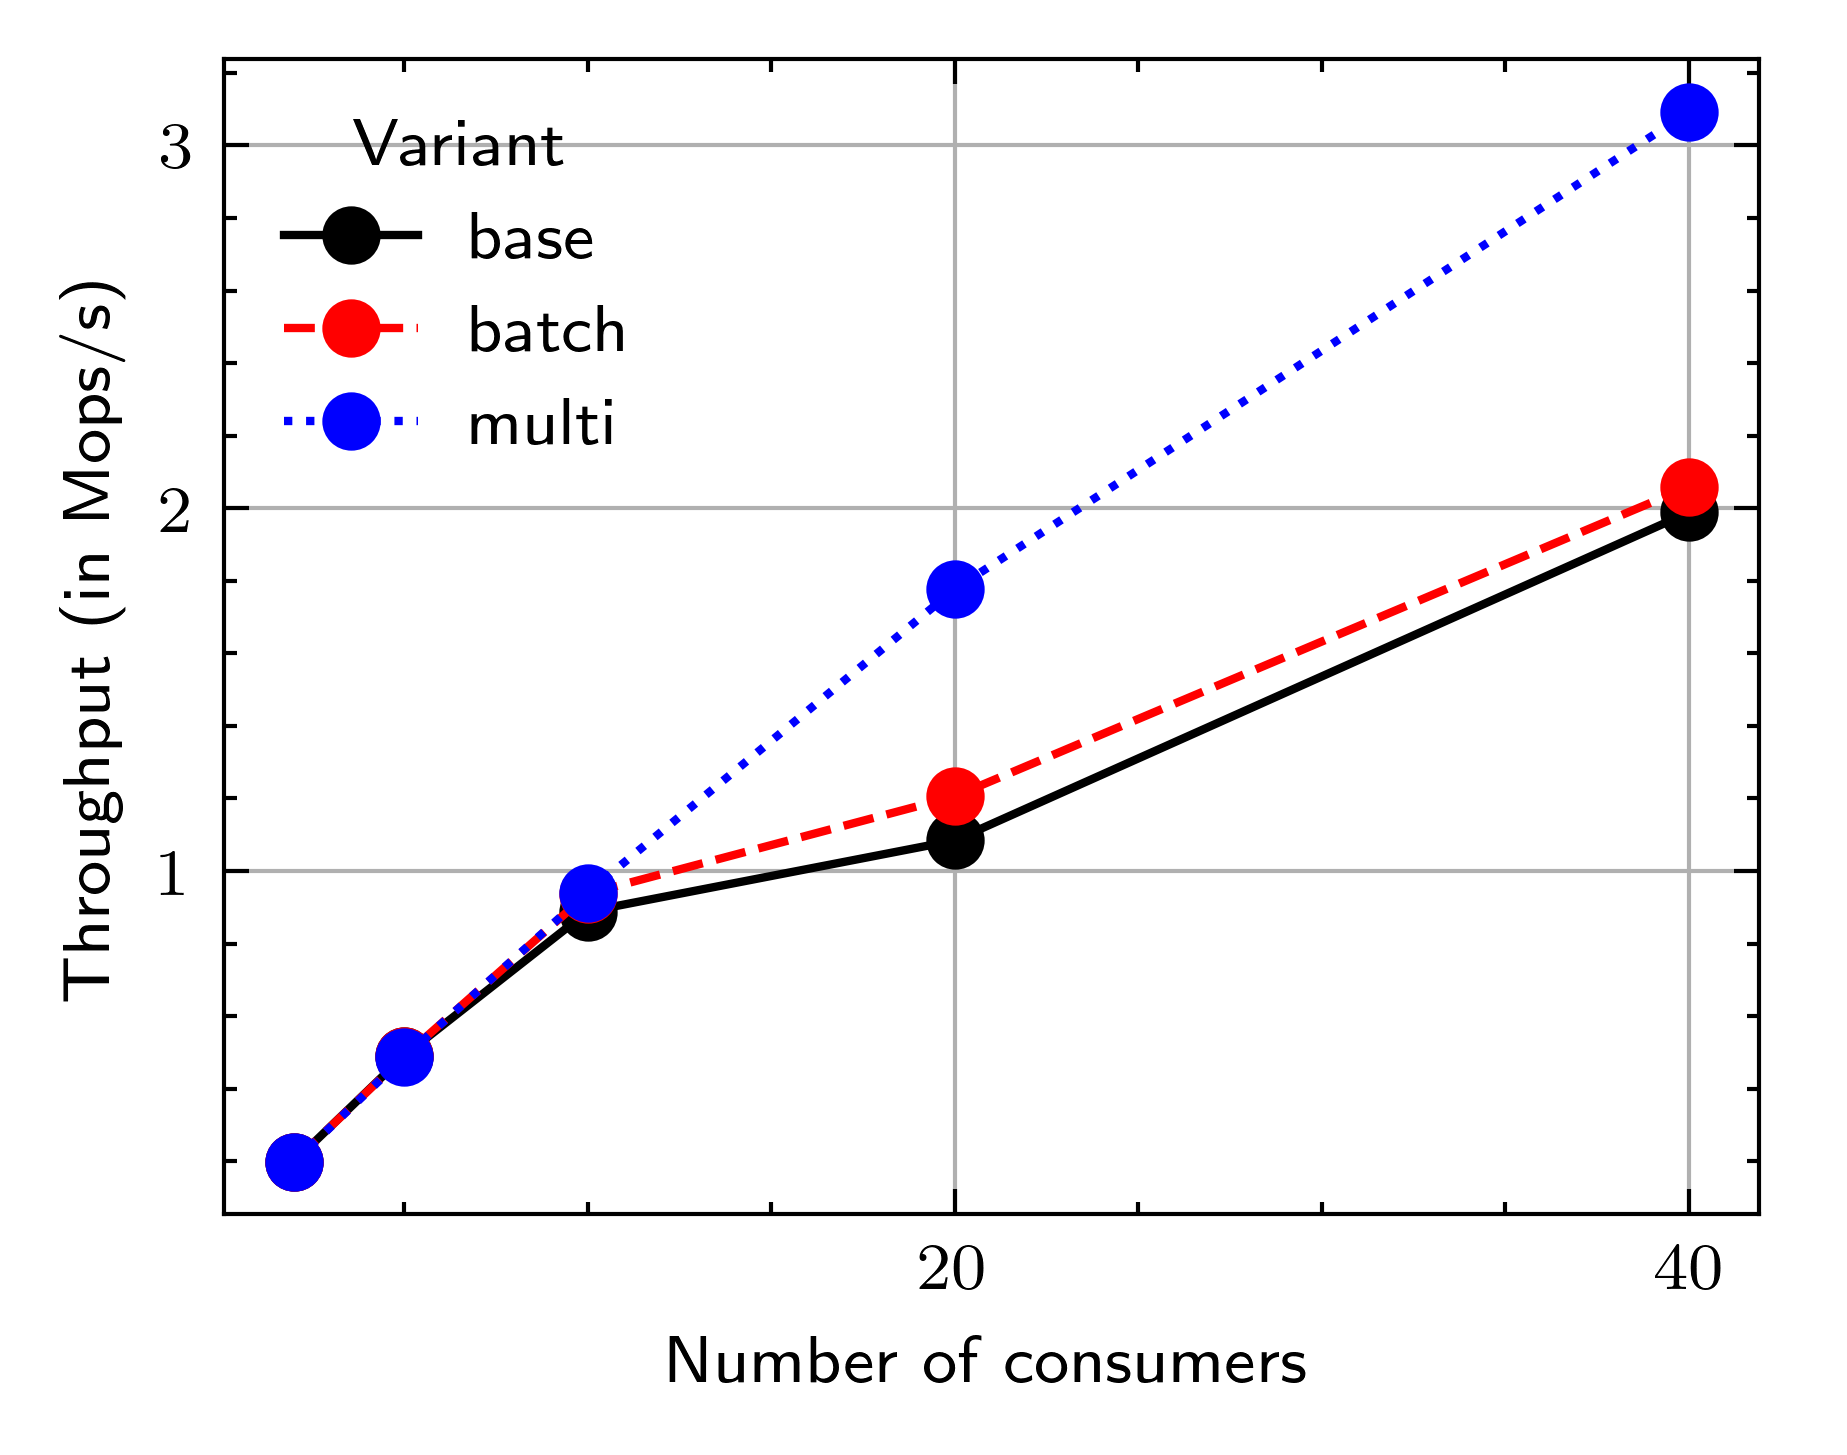

In [56]:
with plt.style.context(['science', 'ieee']):
    throughput.plot.line(
        x='Consumers', y=variants, 
        xlabel='Number of consumers', ylabel='Throughput (in Mops/s)', 
        grid=True, marker='o',)

In [57]:
latency

Variant,Consumers,base,batch,multi,baseline
0,2,12.0,42.00,11.0,10
1,5,16.0,43.00,11.0,10
2,10,22.0,47.99,11.0,10
3,20,23.0,100.67,12.0,10
4,40,24.0,248.37,12.0,10


<Axes: xlabel='Number of consumers', ylabel='Latency (in μs)'>

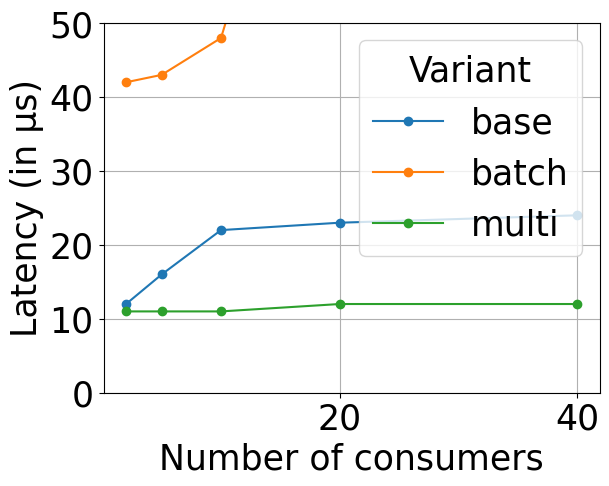

In [58]:
latency.plot.line(
    x='Consumers', y=variants, 
    xlabel='Number of consumers', ylabel='Latency (in μs)', 
    grid=True, marker='o', ylim=[0, 50])

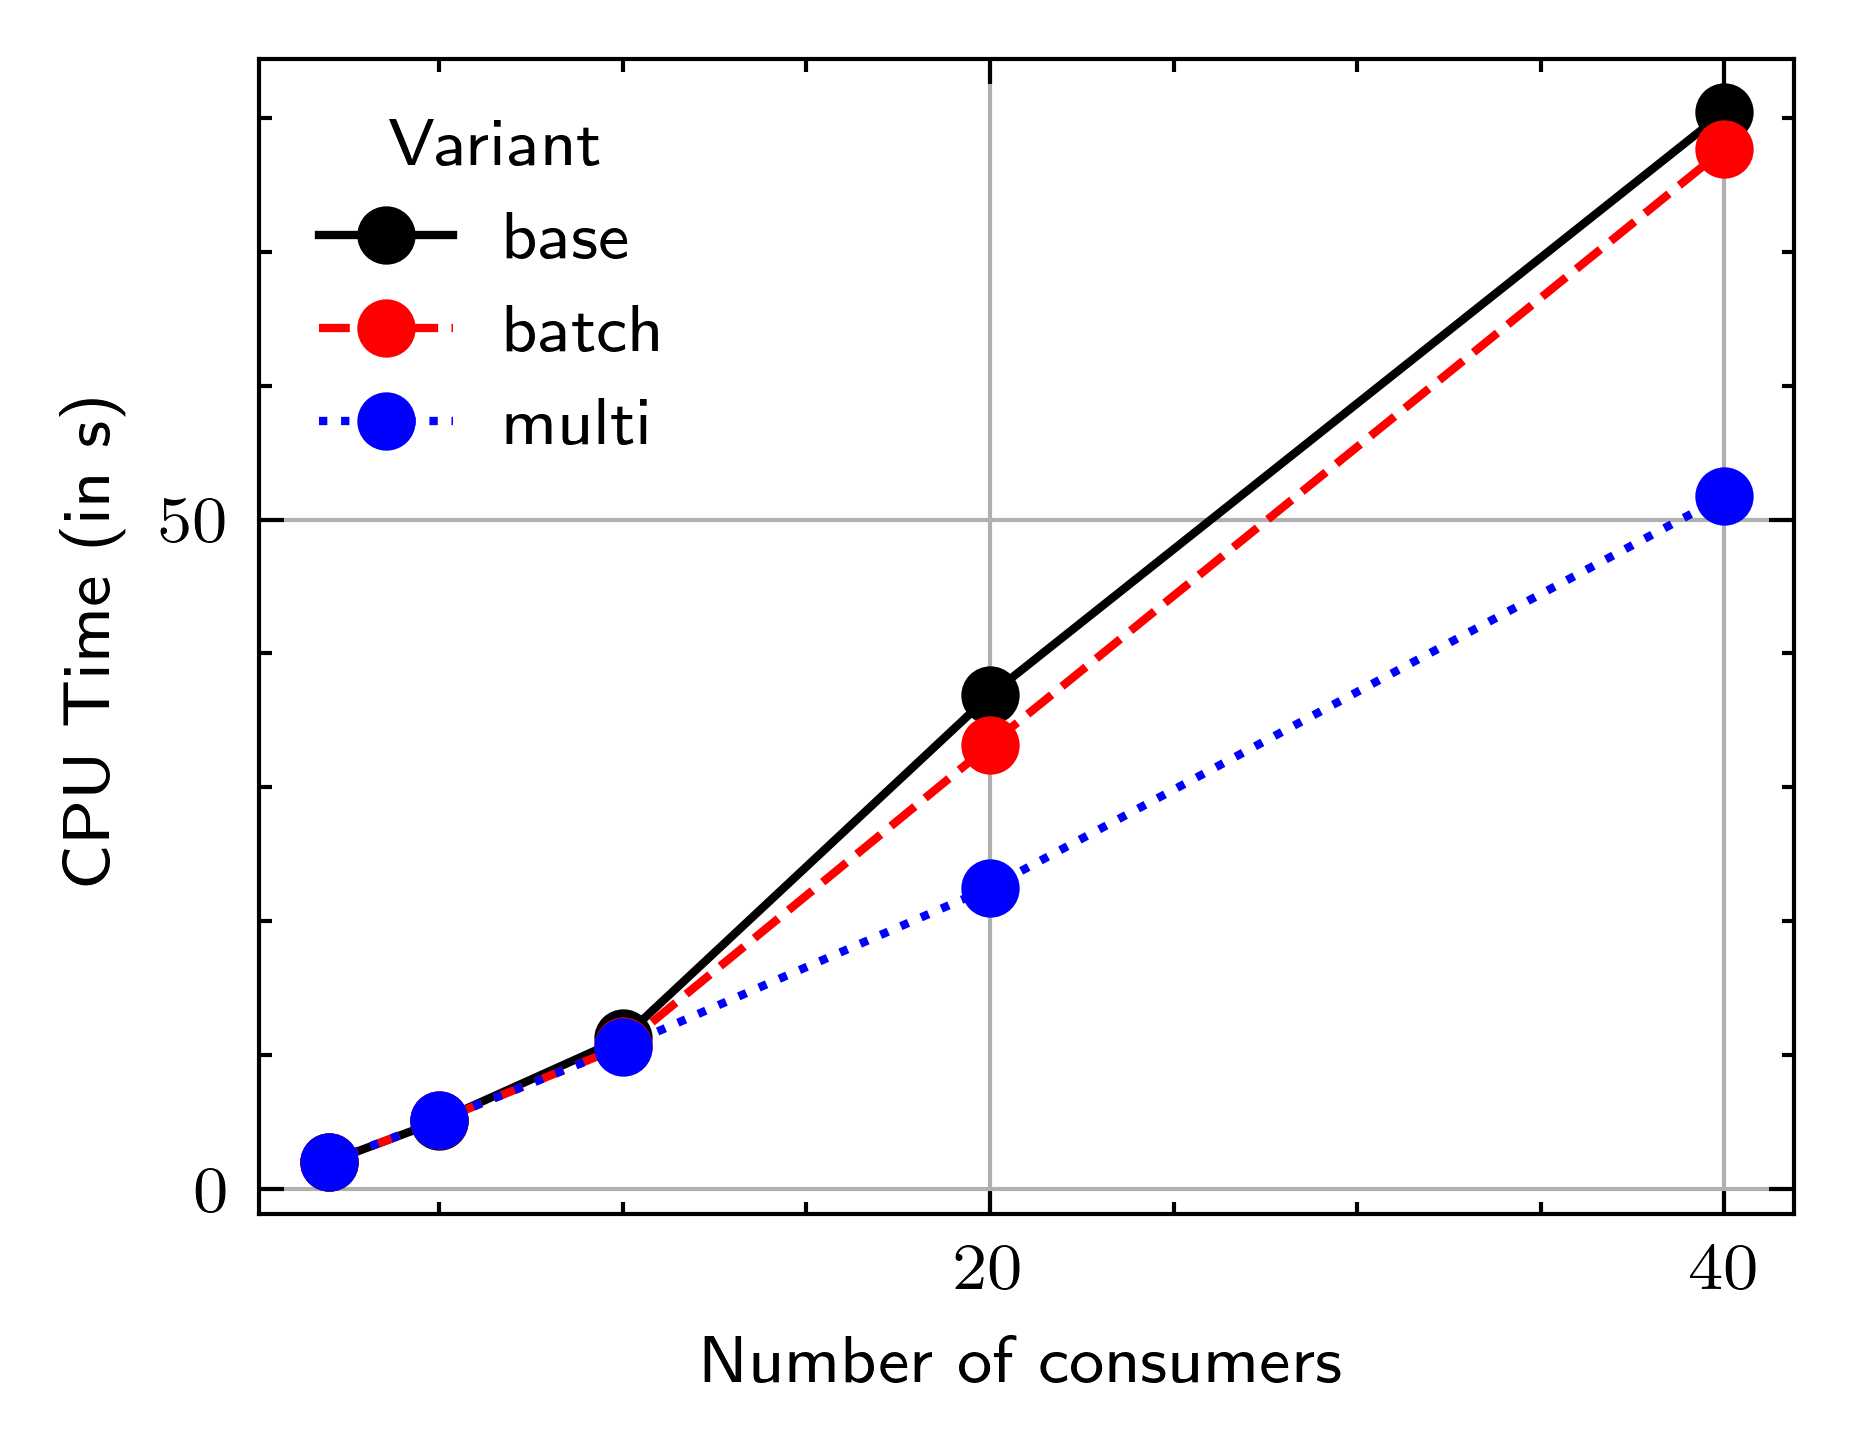

In [59]:
with plt.style.context(['science', 'ieee']):
    cpu_time.plot.line(
        x='Consumers', y=variants, 
        xlabel='Number of consumers', ylabel='CPU Time (in s)', 
        grid=True, marker='o')